In [3]:
import pandas as pd
import numpy as np

In [5]:
df = pd.read_csv('data/fold1.csv')

In [6]:
df

,partition,relevance,qid,0,1,2,3,4,5,6,...,126,127,128,129,130,131,132,133,134,135
0,train,2,1,3,3,0,0,3,1.0,1.000000,...,62,11089534,2,116,64034,13,3,0,0,0.0
1,train,2,1,3,0,3,0,3,1.0,0.000000,...,54,11089534,2,124,64034,1,2,0,0,0.0
2,train,0,1,3,0,2,0,3,1.0,0.000000,...,45,3,1,124,3344,14,67,0,0,0.0
3,train,2,1,3,0,3,0,3,1.0,0.000000,...,56,11089534,13,123,63933,1,3,0,0,0.0
4,train,1,1,3,0,3,0,3,1.0,0.000000,...,64,5,7,256,49697,1,13,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200187,test,1,29998,3,0,1,1,3,1.0,0.000000,...,60,9,1,550,49786,23,102,0,0,0.0
1200188,test,1,29998,3,1,0,0,3,1.0,0.333333,...,91,268,0,181,53904,1,2,0,0,0.0
1200189,test,1,29998,3,0,3,0,3,1.0,0.000000,...,69,14,9,4591,32817,3,9,0,0,0.0
1200190,test,0,29998,3,0,1,1,3,1.0,0.000000,...,51,0,1,1549,59332,10,4,0,0,0.0


# Data preparation

In [8]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
pipe = make_pipeline(StandardScaler())

In [9]:
def get_pointwise_data(df, partition):
    sub_df = df[df['partition'] == partition]
    return sub_df[[str(i) for i in (range(0, len(sub_df.columns) - 3))]], sub_df['relevance']

In [10]:
from sklearn.metrics import ndcg_score

def calculate_ndcg(df, model, partition='vali', k=5):
    df = df[df['partition'] == partition]
    df = df.sample(len(df))
    X, y = get_pointwise_data(df, partition)
    df['pred'] = model.predict(X)
    scores = []
    for qid, group in df.groupby('qid'):
        y = group['relevance']
        preds = group['pred']
        if len(y) < 2:
            continue
        preds = [preds]
        y = [y]
        scores.append(ndcg_score(y, preds, k=k))
        
    return sum(scores) / len(scores)

# Pointwise

In [169]:
X_train, y_train = get_pointwise_data(df, 'train')
X_val, y_val = get_pointwise_data(df, 'vali')

### Linear Regression

In [172]:
from sklearn.linear_model import Ridge

In [180]:
model = Ridge()

In [182]:
model.fit(X_train, y_train)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=2.23254e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge()

In [25]:
preds = model.predict(X_val)

In [27]:
calculate_ndcg(df, model)

0.43590589002546404

In [47]:
np.argsort(-np.abs(model.coef_))

array([ 68,  69,  65,  64,  55,  54,  60,  63,  58,  49,  53,   9,   7,
        67, 102,  59,  45, 101,  52,  47,  48,   4, 100,  50, 104, 103,
        37,   8,   0,   6,  56,  97,  38, 114,  36,  57,  95,  33, 119,
        31,  46, 115,  29,  26,  25, 112,  19, 113,  15, 124,  96,  66,
        21,   1,   2,  51,  28,  43,  23,  22, 125, 118,  87,  39, 117,
        35, 110,  27, 111,  61,  89,  85,  86,   5,  76,  16, 123, 122,
        17, 120,  83,  99,  78,  24, 116,  20,  32, 121,   3,  74,  70,
        72,  30,  81,  41,  13,  98,  34, 108, 128, 109,  62,  82,  77,
        88, 105, 106, 107,  14,  12,  84,  80,  10,  73,  11, 126, 132,
        71,  18, 131,  93,  79,  42,  75,  44,  40,  91, 129,  94,  90,
       130, 133, 134,  92, 135, 127])

In [53]:
from sklearn.metrics import mean_squared_error as mse

In [55]:
mse(y_val, preds)

0.6052895276575369

In [57]:
from sklearn.metrics import accuracy_score
accuracy_score(y_val, preds.round(1).astype(int))

0.5381685716593202

In [184]:
X_train_trans = pipe.fit_transform(X_train)
X_val_trans = pipe.fit_transform(X_val)

In [186]:
model.fit(X_train_trans, y_train)
preds = model.predict(X_val_trans)

In [188]:
np.argsort(-np.abs(model.coef_))

array([ 74,  70,  29, 114,  89,  25,  85, 119, 113, 115, 112, 124, 118,
        19,  15, 123, 117,  44,  84,  80, 111,  40,   4, 110,  30,  87,
         7, 122,  16,  34,  17, 102,  86,   9, 120,  37,   0,  58,  53,
       116,  36,  54, 121,  55,  64, 101,  76,  22,   8,  49,  21,  82,
        38, 103,  33, 129,  83,  71,  31, 100,  73, 109, 108, 104,  97,
        45,  47,  59,  81,  68,   2,  72, 132, 128,  60,  63, 125,  98,
        48,  20,  24,   6,  26,  77,  35,  78,  95,  52,  69, 105,  92,
        32,  28,  39,  50,  13, 126,   1,  91,  41,  75,  27,  56,  65,
       107,  10,  14,  90,  99, 130,  42, 131,  46, 106,  57,  96, 133,
        23,  94,   3,  67,  79,  18,  88,  62,  93, 134,  11,  51,  61,
        43,   5, 127, 135,  12,  66])

In [63]:
mse(y_val, preds)

0.6074451162310454

In [65]:
calculate_ndcg(df, model)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.24684397854396228

### XGBooooooooost

In [67]:
!pip install xgboost

In [69]:
import xgboost as xgb

In [81]:
params = dict(
    n_estimators=1000,
    max_depth=7, 
    eta=0.1, 
    subsample=0.7, 
    colsample_bytree=0.8,
    objective='reg:squarederror',
)
model = xgb.XGBRegressor(**params)
model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [83]:
model.fit(X_train, y_train)
preds = model.predict(X_val)

In [84]:
calculate_ndcg(df, model)

0.5436679853699753

In [89]:
preds = df[df['partition'] == 'vali'].groupby('qid').apply(lambda x: model.predict(X_val.loc[x.index]))
np.mean([ndcg_score([g], [p], k=5) for g, p in zip([group['relevance'] for _, group in df[df['partition'] == 'vali'].groupby('qid')], preds) if len(g) > 1])

/var/folders/0f/3q1rn1_d089d85w405_m22bm0000gn/T/ipykernel_45145/137757040.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  preds = df[df['partition'] == 'vali'].groupby('qid').apply(lambda x: model.predict(X_val.loc[x.index]))


0.5436679853699756

# Pairwise

In [123]:
from collections import defaultdict, Counter
def calculate_ndcg_pair(df, model, partition='vali', k=5):
    df = df[df['partition'] == partition]
    X, y = get_pairwise_data(df, partition)
    df['pred'] = model.predict(X)
    y_true = {}
    d = defaultdict(int)
    qid2id = defaultdict(set)
    # Iterate through each row once
    for _, row in df.iterrows():
        # Update y_true with relevance scores
        y_true[row['index_i']] = row['relevance_i']
        y_true[row['index_j']] = row['relevance_j']
        
        # Update d with label adjustments
        d[row['index_i']] += row['pred']
        d[row['index_j']] -= row['pred']
        
        # Update qid2id with index sets
        qid2id[row['qid']].update([row['index_i'], row['index_j']])
    c = Counter(df['index_i']) + Counter(df['index_j'])
    scores = []
    for qid, group in qid2id.items():
        group = list(group)
        y = [[y_true[el] for el in group]]
        preds = [[d[el] / c[el] for el in group]]
        if len(y[0]) < 2:
            continue
        scores.append(ndcg_score(y, preds, k=k))
        
    return sum(scores) / len(scores)

In [97]:
import itertools
def create_random_pairs(df, max_pairs_per_qid=100):
    # Initialize list to store the results
    pairs_list = []
    
    for qid, df_qid in df.groupby('qid'):
        # If less than 2 documents, skip
        if len(df_qid) < 2:
            continue
        df_docs = df_qid[['relevance']].copy()
        df_docs['index'] = df_docs.index
        df_docs['key'] = 1  # Add dummy key for cross join
        
        df_pairs = df_docs.merge(df_docs, on='key', suffixes=('_i', '_j'))
        df_pairs = df_pairs.drop('key', axis=1)
        
        # Remove self-pairs and duplicates
        df_pairs = df_pairs[df_pairs['index_i'] < df_pairs['index_j']]
        
        # Drop ties (where relevance_i == relevance_j)
        df_pairs = df_pairs[df_pairs['relevance_i'] != df_pairs['relevance_j']]
        
        if df_pairs.empty:
            continue
        
        # Randomly sample up to max_pairs_per_qid pairs
        df_sampled_pairs = df_pairs.sample(n=min(len(df_qid), len(df_pairs)), random_state=42)
        
        # Assign labels
        df_sampled_pairs['label'] = np.where(df_sampled_pairs['relevance_i'] > df_sampled_pairs['relevance_j'], 1, 0)
        
        features_columns = df_qid.columns[3:] 
        
        features_i = df_qid.loc[df_sampled_pairs['index_i'], features_columns].reset_index(drop=True)
        features_j = df_qid.loc[df_sampled_pairs['index_j'], features_columns].reset_index(drop=True)
        
        # Combine into a single DataFrame
        df_pairs_features = pd.concat([
            df_sampled_pairs.reset_index(drop=True),
            features_i.add_suffix('_i'),
            features_j.add_suffix('_j')
        ], axis=1)
        
        # Add qid column
        df_pairs_features['qid'] = qid
        df_pairs_features['partition'] = df_qid['partition'].iloc[0]
        
        # Append to list
        pairs_list.append(df_pairs_features)
    # Concatenate all pairs
    df_all_pairs = pd.concat(pairs_list, ignore_index=True)

    return df_all_pairs

In [99]:
def get_pairwise_data(df, partition):
    sub_df = df[df['partition'] == partition]
    return sub_df[[str(i) + '_' + item for i in (range(0, 136)) for item in ('i', 'j')]], sub_df['label']

In [102]:
len(df.groupby('qid'))

10000

In [104]:
df['partition'].iloc[0]

'train'

In [106]:
df_pairs = create_random_pairs(df)

In [108]:
df_pairs

,relevance_i,index_i,relevance_j,index_j,label,0_i,1_i,2_i,3_i,4_i,...,128_j,129_j,130_j,131_j,132_j,133_j,134_j,135_j,qid,partition
0,2,56,0,81,1,3,0,3,3,3,...,30,23860,63634,3,4,0,0,0.0,1,train
1,0,29,2,58,0,3,0,0,0,3,...,0,1506,48469,1,14,0,0,0.0,1,train
2,1,41,0,68,1,3,0,3,0,3,...,30,23929,63634,2,3,0,0,0.0,1,train
3,1,4,0,40,1,3,0,3,0,3,...,0,8590,17807,1,3,0,0,0.0,1,train
4,1,6,0,50,1,3,0,3,0,3,...,30,21283,63181,2,4,0,0,0.0,1,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192833,0,1200161,2,1200185,0,3,0,1,1,3,...,9,4162,32817,3,9,0,0,0.0,29998,test
1192834,2,1200124,0,1200151,1,3,3,3,3,3,...,3,771,54662,22,4,0,0,0.0,29998,test
1192835,2,1200124,0,1200125,1,3,3,3,3,3,...,1,53700,50707,3,1,0,9,14.3,29998,test
1192836,2,1200108,0,1200153,1,3,0,2,2,3,...,15,6288,55624,7,12,0,0,0.0,29998,test


In [110]:
X_train, y_train = get_pairwise_data(df_pairs, 'train')
X_val, y_val = get_pairwise_data(df_pairs, 'vali')

### Logistic Regression

In [112]:
from sklearn.linear_model import LogisticRegression

In [ ]:
norma

In [115]:
model = LogisticRegression()

In [117]:
model.fit(X_train, y_train)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [118]:
preds = model.predict(X_val)

In [125]:
calculate_ndcg_pair(df_pairs, model)

/var/folders/0f/3q1rn1_d089d85w405_m22bm0000gn/T/ipykernel_45145/1840603243.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred'] = model.predict(X)


0.24362136113862004

### XGBoost

In [134]:
params = dict(
    n_estimators=1000,
    max_depth=7, 
    eta=0.1, 
    subsample=0.7, 
    colsample_bytree=0.8,
    # objective='reg:squarederror',
)
model = xgb.XGBClassifier(**params)
model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric=None,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_parallel_tree=None, ...)

In [136]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric=None,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_parallel_tree=None, ...)

In [137]:
preds = model.predict(X_val)

In [138]:
accuracy_score(y_val, preds)

0.6611272232630958

In [139]:
calculate_ndcg_pair(df_pairs, model)

/var/folders/0f/3q1rn1_d089d85w405_m22bm0000gn/T/ipykernel_45145/1840603243.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred'] = model.predict(X)


0.3420823130917778

### RankNet

In [145]:
X_train, y_train = get_pointwise_data(df, 'train')
X_val, y_val = get_pointwise_data(df, 'vali')

In [153]:
model = xgb.XGBRanker(
    n_estimators=1000,
    learning_rate=0.1,
    objective="rank:pairwise",
    reg_lambda=0.05,
    early_stopping_rounds=100,
)

group_train = df[df['partition'] == 'train'].groupby('qid').size().to_numpy()
group_valid = df[df['partition'] == 'vali'].groupby('qid').size().to_numpy()

model.fit(
    X_train,
    y_train,
    
    group=group_train,
    eval_group=[group_valid],
    eval_set=[(X_val, y_val)]
)

XGBRanker(base_score=None, booster=None, callbacks=None, colsample_bylevel=None,
          colsample_bynode=None, colsample_bytree=None, device=None,
          early_stopping_rounds=100, enable_categorical=False, eval_metric=None,
          feature_types=None, gamma=None, grow_policy=None,
          importance_type=None, interaction_constraints=None, learning_rate=0.1,
          max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
          max_delta_step=None, max_depth=None, max_leaves=None,
          min_child_weight=None, missing=nan, monotone_constraints=None,
          multi_strategy=None, n_estimators=1000, n_jobs=None,
          num_parallel_tree=None, objective='rank:pairwise', ...)

In [ ]:
preds = df[df['partition'] == 'vali'].groupby('qid').apply(lambda x: model.predict(X_val.loc[x.index]))
np.mean([ndcg_score([g], [p]) for g, p in zip([group['relevance'] for _, group in df[df['partition'] == 'vali'].groupby('qid')], preds) if len(g) > 1])

In [154]:
calculate_ndcg(df, model)

0.5436451833907125

### LambdaMART

In [157]:
model = xgb.XGBRanker(
    n_estimators=1000,
    learning_rate=0.1,
    objective="rank:ndcg",
    reg_lambda=0.05,
    early_stopping_rounds=100,

)

group_train = df[df['partition'] == 'train'].groupby('qid').size().to_numpy()
group_valid = df[df['partition'] == 'vali'].groupby('qid').size().to_numpy()

model.fit(
    X_train,
    y_train,
    group=group_train,
    eval_group=[group_valid],
    eval_set=[(X_val, y_val)]
)

XGBRanker(base_score=None, booster=None, callbacks=None, colsample_bylevel=None,
          colsample_bynode=None, colsample_bytree=None, device=None,
          early_stopping_rounds=100, enable_categorical=False, eval_metric=None,
          feature_types=None, gamma=None, grow_policy=None,
          importance_type=None, interaction_constraints=None, learning_rate=0.1,
          max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
          max_delta_step=None, max_depth=None, max_leaves=None,
          min_child_weight=None, missing=nan, monotone_constraints=None,
          multi_strategy=None, n_estimators=1000, n_jobs=None,
          num_parallel_tree=None, random_state=None, ...)

In [158]:
calculate_ndcg(df, model)

0.5434842252634715

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

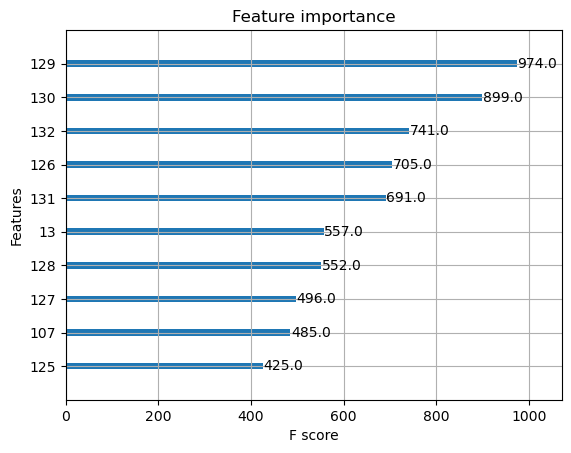

In [163]:
xgb.plot_importance(model, max_num_features=10)